# Vegetation Phenology

* **Products used:** 
[s2_l2a](https://explorer.digitalearth.africa/s2_l2a),
[crop_mask](https://explorer.digitalearth.africa/products/crop_mask)

## Background
Phenology is the study of plant and animal life cycles in the context of the seasons.
It can be useful in understanding the life cycle trends of crops and how the growing seasons are affected by changes in climate.
For more information, see the [USGS page on deriving phenology from NDVI time-series](https://www.usgs.gov/land-resources/eros/phenology/science/deriving-phenological-metrics-ndvi?qt-science_center_objects=0#qt-science_center_objects).

## Description

This notebook demonstrates how to calculate vegetation phenology statistics using the DE Africa function [xr_phenology](../Tools/deafrica_tools/temporal.py).  To detect changes in plant life for Sentinel-2, the script uses either the **Normalized Difference Vegetation Index (NDVI)** or the **Enhanced Vegetation Index (EVI)**, which are common proxies for vegetation growth and health.

The outputs of this notebook can be used to assess spatio-temporal differences in the growing seasons of agriculture fields or native vegetation.

This notebook demonstrates the following steps:

1. Load cloud-masked Sentinel 2 data for an area of interest.
2. Calculate a vegetation proxy index (NDVI or EVI).
3. Generate a zonal time series of vegetation health.
4. Complete and smooth the vegetation timeseries to remove gaps and noise.
5. Calculate phenology statistics on a simple 1D vegetation time series.
6. Calculate per-pixel phenology statistics.
7. Optional: Calculating generic temporal statistics usng the hdstats library.

***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Load key Python packages and supporting functions for the analysis.

In [1]:
%matplotlib inline

import datetime as dt
from datetime import datetime
import os

import datacube
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import mpl_toolkits.axisartist as AA
import numpy as np
import pandas as pd
import xarray as xr
from datacube.utils.aws import configure_s3_access
from datacube.utils.geometry import Geometry
from mpl_toolkits.axes_grid1 import host_subplot

from deafrica_tools.areaofinterest import define_area
from deafrica_tools.bandindices import calculate_indices
from deafrica_tools.datahandling import load_ard
from deafrica_tools.plotting import display_map, rgb
from deafrica_tools.spatial import xr_rasterize
from deafrica_tools.temporal import temporal_statistics, xr_phenology

configure_s3_access(aws_unsigned=True, cloud_defaults=True)

### Connect to the datacube

Connect to the datacube so we can access DE Africa data.
The `app` parameter is a unique name for the analysis which is based on the notebook file name.

In [2]:
dc = datacube.Datacube(app="Vegetation_phenology")

### Analysis parameters

The following cell sets important parameters for the analysis:

* `veg_proxy`: Band index to use as a proxy for vegetation health e.g. `'NDVI'` or `'EVI'`.
* `lat`: The central latitude to analyse (e.g. `-10.6996`).
* `lon`: The central longitude to analyse (e.g. `35.2708`).
* `buffer`: The number of square degrees to load around the central latitude and longitude.
For reasonable loading times, set this as `0.1` or lower.
* `time_range`: The year range to analyse (e.g. `('2019-01', '2019-06')`).

#### Select location
To define the area of interest, there are two methods available:

1. By specifying the latitude, longitude, and buffer. This method requires you to input the central latitude, central longitude, and the buffer value in square degrees around the center point you want to analyze. For example, `lat = 10.338`, `lon = -1.055`, and `buffer = 0.1` will select an area with a radius of 0.1 square degrees around the point with coordinates (10.338, -1.055).

2. By uploading a polygon as a `GeoJSON or Esri Shapefile`. If you choose this option, you will need to upload the geojson or ESRI shapefile into the Sandbox using Upload Files button <img align="top" src="../Supplementary_data/upload_files_icon.png"> in the top left corner of the Jupyter Notebook interface. ESRI shapefiles must be uploaded with all the related files `(.cpg, .dbf, .shp, .shx)`. Once uploaded, you can use the shapefile or geojson to define the area of interest. Remember to update the code to call the file you have uploaded.

To use one of these methods, you can uncomment the relevant line of code and comment out the other one. To comment out a line, add the `"#"` symbol before the code you want to comment out. By default, the first option which defines the location using latitude, longitude, and buffer is being used.

In [3]:
# Set the vegetation proxy to use
veg_proxy = "NDVI"

time_range = ("2019-01-01", "2020-12-20")

In [4]:
# Method 1: Specify the latitude, longitude, and buffer
aoi = define_area(lat=9.775557, lon=8.947609, buffer=0.02)

# Method 2: Use a polygon as a GeoJSON or Esri Shapefile.
# aoi = define_area(vector_path='aoi.shp')

# Create a geopolygon and geodataframe of the area of interest
geopolygon = Geometry(aoi["features"][0]["geometry"], crs="epsg:4326")
geopolygon_gdf = gpd.GeoDataFrame(geometry=[geopolygon], crs=geopolygon.crs)

# Get the latitude and longitude range of the geopolygon
lat_range = (geopolygon_gdf.total_bounds[1], geopolygon_gdf.total_bounds[3])
lon_range = (geopolygon_gdf.total_bounds[0], geopolygon_gdf.total_bounds[2])

## View the selected location
The next cell will display the selected area on an interactive map.
Feel free to zoom in and out to get a better understanding of the area you'll be analysing.
Clicking on any point of the map will reveal the latitude and longitude coordinates of that point.

In [5]:
display_map(x=lon_range, y=lat_range)

## Load cloud-masked Sentinel-2 data

The first step is to load Sentinel-2 data for the specified area of interest and time range. 
The `load_ard` function is used here to load data that has been masked for cloud, shadow and quality filters, making it ready for analysis.

In [6]:
# Create a reusable query
query = {
    "y": lat_range,
    "x": lon_range,
    "time": time_range,
    "measurements": ["red", "green", "blue", "nir"],
    "resolution": (-20, 20),
    "output_crs": "epsg:6933",
    "group_by": "solar_day",
}

# Load available data from Sentinel-2
ds = load_ard(
    dc=dc,
    products=["s2_l2a"],
    mask_filters=[("opening", 3), ("dilation", 3)],
    **query,
)

print(ds)

Using pixel quality parameters for Sentinel 2
Finding datasets
    s2_l2a
Applying morphological filters to pq mask [('opening', 3), ('dilation', 3)]
Applying pixel quality/cloud mask
Loading 143 time steps


/usr/local/lib/python3.10/dist-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


<xarray.Dataset>
Dimensions:      (time: 143, y: 252, x: 194)
Coordinates:
  * time         (time) datetime64[ns] 2019-01-05T09:58:08 ... 2020-12-20T09:...
  * y            (y) float64 1.244e+06 1.244e+06 ... 1.239e+06 1.239e+06
  * x            (x) float64 8.614e+05 8.614e+05 ... 8.652e+05 8.652e+05
    spatial_ref  int32 6933
Data variables:
    red          (time, y, x) float32 1.302e+03 1.41e+03 ... 1.804e+03 1.794e+03
    green        (time, y, x) float32 904.0 1.001e+03 ... 1.222e+03 1.158e+03
    blue         (time, y, x) float32 615.0 668.0 684.0 ... 601.0 806.0 806.0
    nir          (time, y, x) float32 2.366e+03 2.3e+03 ... 2.964e+03 2.81e+03
Attributes:
    crs:           epsg:6933
    grid_mapping:  spatial_ref


### Clip the datasets to the shape of the area of interest
A geopolygon represents the bounds and not the actual shape because it is designed to represent the extent of the geographic feature being mapped, rather than the exact shape. In other words, the geopolygon is used to define the outer boundary of the area of interest, rather than the internal features and characteristics.

Clipping the data to the exact shape of the area of interest is important because it helps ensure that the data being used is relevant to the specific study area of interest. While a geopolygon provides information about the boundary of the geographic feature being represented, it does not necessarily reflect the exact shape or extent of the area of interest.

In [7]:
# Rasterise the area of interest polygon
aoi_raster = xr_rasterize(gdf=geopolygon_gdf, da=ds, crs=ds.crs)
# Mask the dataset to the rasterised area of interest
ds = ds.where(aoi_raster == 1)

## Mask region with DE Africa's cropland extent map

Load the cropland mask over the region of interest.


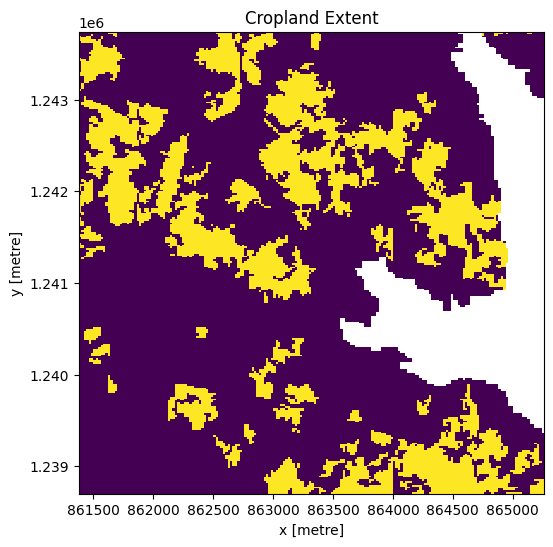

In [8]:
cm = dc.load(
    product="crop_mask",
    time=("2019"),
    measurements="filtered",
    resampling="nearest",
    like=ds.geobox,
).filtered.squeeze()

cm.where(cm < 255).plot.imshow(
    add_colorbar=False, figsize=(6, 6)
)  # we filter to <255 to omit missing data
plt.title("Cropland Extent");

Now we will use the cropland map to mask the regions in the Sentinel-2 data that only have cropping. 

In [9]:
# Filter out the no-data pixels (255) and non-crop pixels (0) from the cropland map and
# mask the Sentinel-2 data.
ds = ds.where(cm == 1)

**Once the load is complete**, we can plot some of the images as as a true-colour image using the `rgb` function.  

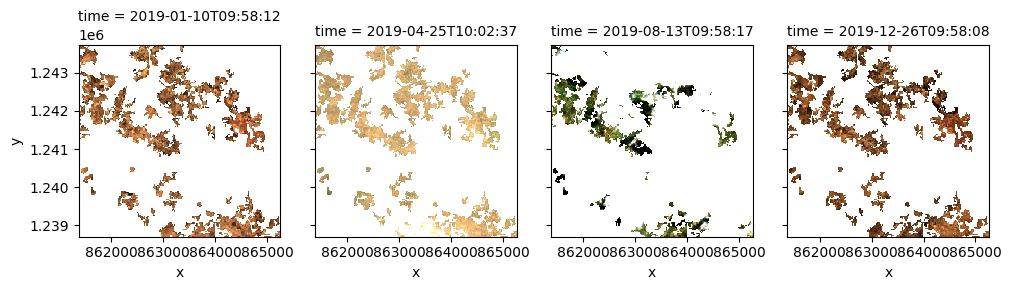

In [10]:
rgb(ds, index=[1, 22, 44, 70], col_wrap=4, size=3)

## Compute band indices

This study measures the presence of vegetation through either the `normalised difference vegetation index (NDVI)` or the `enhanced vegetation index (EVI)`.
The index that will be used is dictated by the `veg_proxy` parameter that was set in the "Analysis parameters" section.

The normalised difference vegetation index (NDVI) requires the `red` and `nir` (near-infra red) bands. 
The formula is

$$
\begin{aligned}
\text{NDVI} & = \frac{(\text{NIR} - \text{Red})}{(\text{NIR} + \text{Red})} \\
\end{aligned}
$$

The Enhanced Vegetation Index requires the `red`, `nir` and `blue` bands.
The formula is

$$
\begin{aligned}
\text{EVI} & = \frac{2.5 \times (\text{NIR} - \text{Red})}{(\text{NIR} + 6 \times \text{Red} - 7.5 \times \text{Blue} + 1)} \\
\end{aligned}
$$


Both indices are available through the [calculate_indices](../Frequently_used_code/Calculating_band_indices.ipynb) function, imported from [deafrica_tools.bandindices](https://docs.digitalearthafrica.org/en/latest/sandbox/notebooks/Tools/gen/deafrica_tools.bandindices.html).
Here, we use `satellite_mission='s2'` since we're working with Sentinel-2 data.

In [11]:
# Calculate the chosen vegetation proxy index and add it to the loaded data set
ds = calculate_indices(ds, index=veg_proxy, satellite_mission="s2")

The vegetation proxy index should now appear as a data variable, along with the loaded measurements, in the `ds` object.

## Plot the vegetation index over time

To get an idea of how the vegetation health changes throughout the year(s), we can plot a zonal time series over the region of interest. First we will do a simple plot of the zonal mean of the data.  


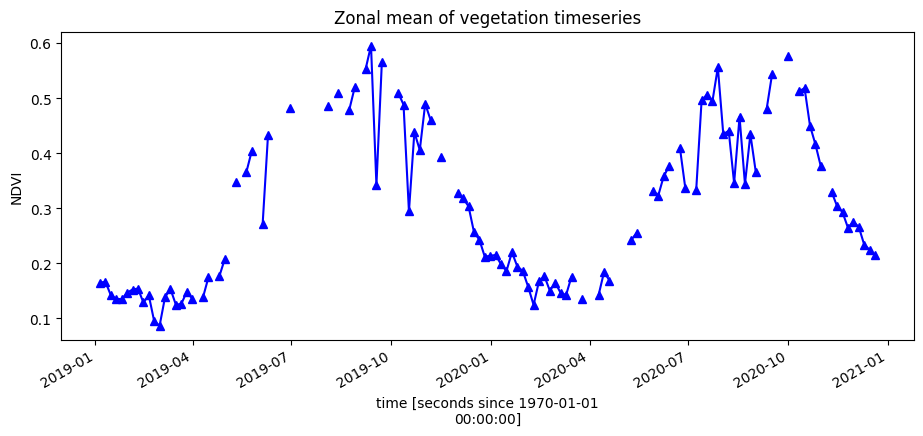

In [12]:
ds.NDVI.mean(["x", "y"]).plot.line("b-^", figsize=(11, 4))
plt.title("Zonal mean of vegetation timeseries");

## Smoothing/Interpolating vegetation time-series

Here, we will smooth and interpolate the data to ensure we working with a consistent time-series. This is a very important step in the workflow and there are many ways to smooth, interpolate, gap-fill, remove outliers, or curve-fit the data to ensure a useable time-series. If not using the default example, you may have to define additional methods to those used here.

To do this we take two steps:

1. Resample the data to fortnightly time-steps using the fortnightly median
2. Calculate a rolling mean with a window of 4 steps

In [13]:
resample_period = "2W"
window = 4

veg_smooth = (
    ds[veg_proxy]
    .resample(time=resample_period)
    .median()
    .rolling(time=window, min_periods=1)
    .mean()
)

Alternatively, lets complete the timeseries using the DE Africa function `deafrica_temporal_statistics.fast_complete()`

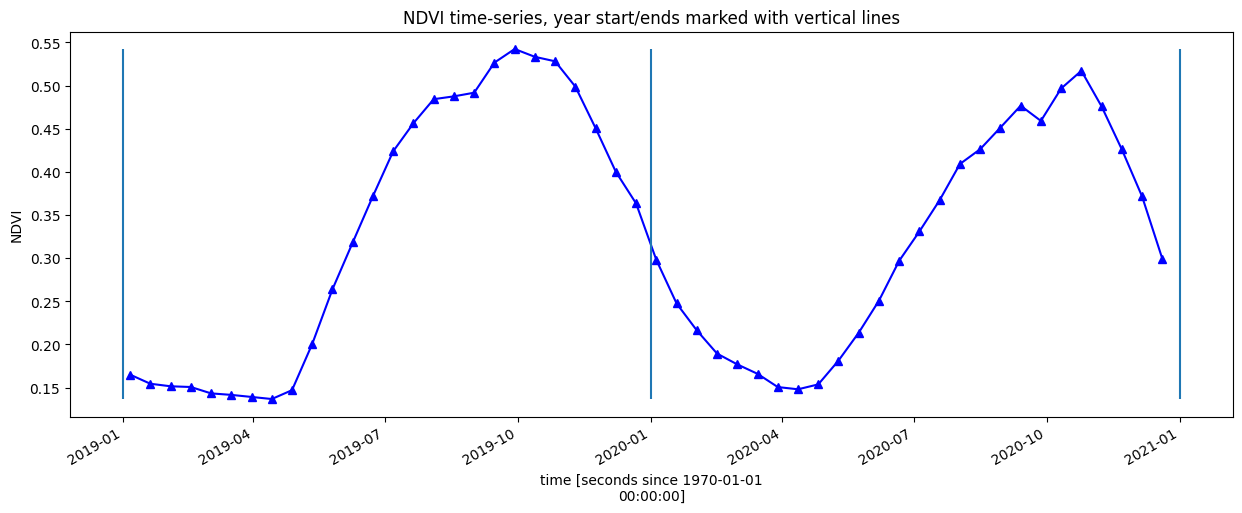

In [14]:
veg_smooth_1D = veg_smooth.mean(["x", "y"])
veg_smooth_1D.plot.line("b-^", figsize=(15, 5))
_max = veg_smooth_1D.max()
_min = veg_smooth_1D.min()
plt.vlines(np.datetime64("2019-01-01"), ymin=_min, ymax=_max)
plt.vlines(np.datetime64("2020-01-01"), ymin=_min, ymax=_max)
plt.vlines(np.datetime64("2021-01-01"), ymin=_min, ymax=_max)
plt.title(veg_proxy + " time-series, year start/ends marked with vertical lines")
plt.ylabel(veg_proxy);

## Calculate phenology statistics using `xr_phenology`

The DE Africa function `xr_phenology` can calculate a number of land-surface phenology statistics that together describe the characteristics of a plant's lifecycle.  The function can calculate the following statistics on either a zonal timeseries (like the one above), or on a per-pixel basis:

            SOS = Date of start of season
            POS = Date of peak of season
            EOS = Date of end of season
            vSOS = Value at start of season
            vPOS = Value at peak of season
            vEOS = Value at end of season
            Trough = Minimum value of season
            LOS = Length of season (Days)
            AOS = Amplitude of season (in value units)
            ROG = Rate of greening
            ROS = Rate of senescence

By default the function will return all the statistics as an `xarray.Dataset`, to return only a subset of these statistics pass a list of the desired statistics to the function e.g. `stats=['SOS', 'EOS', 'ROG']`.

The `xr_phenology` function also allows for interpolating and/or smoothing the time-series in the same way as we did above, the interpolating/smoothing will occur before the statistics are calculated. 

See the [deafrica_tools.temporal](../Tools/deafrica_tools/temporal.py) script for more information on each of the parameters in `xr_phenology`.

### Zonal phenology statistics

To help us understand what these statistics refer too, lets first pass the simpler zonal mean (mean of all pixels in the image) time-series to the function and plot the results on the same curves as above.

First, provide a list of statistics to calculate with the parameter, `pheno_stats`.

`method_sos` : If 'first' then vSOS is estimated as the first positive slope on the greening side of the curve. If 'median', then vSOS is estimated as the median value of the postive slopes on the greening side of the curve.

`method_eos` : If 'last' then vEOS is estimated as the last negative slope on the senescing side of the curve. If 'median', then vEOS is estimated as the 'median' value of the negative slopes on the senescing side of the curve.

In [15]:
basic_pheno_stats = [
    "SOS",
    "vSOS",
    "POS",
    "vPOS",
    "EOS",
    "vEOS",
    "Trough",
    "LOS",
    "AOS",
    "ROG",
    "ROS",
]
method_sos = "first"
method_eos = "last"

Plot the results with our statistcs annotated on the plot

In [16]:
# find all the years to assist with plotting
years = veg_smooth_1D.groupby("time.year")

# store results in dict
pheno_results = {}

# loop through years and calculate phenology
for y, year in years:
    # calculate stats
    stats = xr_phenology(
        year,
        method_sos=method_sos,
        method_eos=method_eos,
        stats=basic_pheno_stats,
        verbose=False,
    )
    # add results to dict
    pheno_results[str(y)] = stats

df_dict = {}
for key, value in pheno_results.items():
    df_dict_1 = {}
    for b in value.data_vars:
        if value[b].dtype == np.dtype("<M8[ns]") or value[b].dtype == np.dtype("int16"):
            result = pd.to_datetime(value[b].values)
        else:
            result = round(float(value[b].values), 3)
        df_dict_1[b] = result
    df_dict[key] = df_dict_1
            
df = (pd.DataFrame(df_dict)).T
df

,SOS,vSOS,POS,vPOS,EOS,vEOS,Trough,LOS,AOS,ROG,ROS
2019,2019-04-14,0.137,2019-09-29,0.542,2019-12-22,0.363,0.137,252.0,0.406,0.002,-0.002
2020,2020-04-12,0.148,2020-10-25,0.517,2020-12-20,0.299,0.148,252.0,0.369,0.002,-0.004


Plot the results with our statistcs annotated on the plot

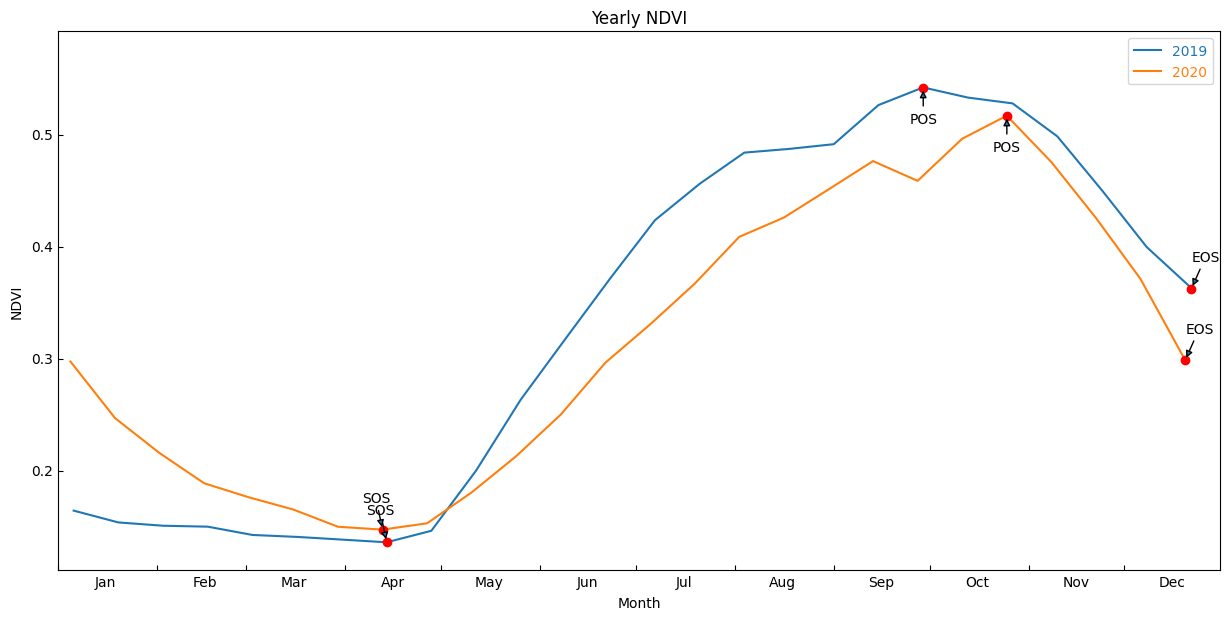

In [17]:
# Figure to which the subplot will be added
fig = plt.figure(figsize=(15, 7))
# Create a subplot that can act as a host to parasitic axes
host = host_subplot(111, figure=fig, axes_class=AA.Axes)
# fig, ax = plt.subplots()


# Function to use to edit the axes of the plot
def adjust_axes(ax):
    # Set the location of the major and minor ticks.
    ax.xaxis.set_major_locator(mpl.dates.MonthLocator())
    ax.xaxis.set_minor_locator(mpl.dates.MonthLocator(bymonthday=16))

    # Format the major and minor tick labels.
    
    ax.xaxis.set_major_formatter(mpl.ticker.NullFormatter())
    ax.xaxis.set_minor_formatter(mpl.dates.DateFormatter("%b"))
    

#     # Turn off unnecessary ticks.
    ax.axis["bottom"].minor_ticks.set_visible(False)

    ax.axis["top"].major_ticks.set_visible(False)
    ax.axis["top"].minor_ticks.set_visible(False)

    ax.axis["right"].major_ticks.set_visible(False)
    ax.axis["right"].minor_ticks.set_visible(False)


# Find all the years to assist with plotting
years = veg_smooth_1D.groupby("time.year")

# Counter to aid in plotting.
counter = 0

for y, year in years:
    # Grab all the values we need for plotting.
    eos = df.loc[str(y)].EOS
    sos = df.loc[str(y)].SOS
    pos = df.loc[str(y)].POS

    veos = df.loc[str(y)].vEOS
    vsos = df.loc[str(y)].vSOS
    vpos = df.loc[str(y)].vPOS

    if counter == 0:
        ax = host
    else:
        # Create the secondary axis.
        ax = host.twiny()

    # Plot the data
    year.plot(ax=ax, label=y)
    # add start of season
   
    ax.plot(sos, vsos, "or")
    ax.annotate(
        "SOS",
        xy=(sos, vsos),
        xytext=(-15, 20),
        textcoords="offset points",
        arrowprops=dict(arrowstyle="-|>"),
    )

    # add end of season
    ax.plot(eos, veos, "or")
    ax.annotate(
        "EOS",
        xy=(eos, veos),
        xytext=(0, 20),
        textcoords="offset points",
        arrowprops=dict(arrowstyle="-|>"),
    )

    # add peak of season
    ax.plot(pos, vpos, "or")
    ax.annotate(
        "POS",
        xy=(pos, vpos),
        xytext=(-10, -25),
        textcoords="offset points",
        arrowprops=dict(arrowstyle="-|>"),
    )

    # Set the x-axis limits
    min_x = dt.date(y, 1, 1)
    max_x = dt.date(y, 12, 31)
    ax.set_xlim(min_x, max_x)
    
    adjust_axes(ax)
    counter += 1
    

host.legend(labelcolor="linecolor")
host.set_ylim([_min - 0.025, _max.values + 0.05])

plt.ylabel(veg_proxy)
plt.xlabel("Month")

plt.title("Yearly " + veg_proxy);

## Per-pixel phenology statistics

We can now calculate the statistics for every pixel in our time-series and plot the results.

In [18]:
# find all the years to assist with plotting
years = veg_smooth.groupby("time.year")

# get list of years in ts to help with looping
years_int = [y[0] for y in years]

# store results in dict
pheno_results = {}

# loop through years and calculate phenology
for year in years_int:
    # select year
    da = dict(years)[year]

    # calculate stats
    stats = xr_phenology(
        da,
        method_sos=method_sos,
        method_eos=method_eos,
        stats=basic_pheno_stats,
        verbose=False,
    )
    # add results to dict
    pheno_results[str(year)] = stats

The phenology statistics have been calculated seperately for every pixel in the image.  Let's plot each of them to see the results. 

Below, pick a year from the phenology results to plot. 

In [19]:
# Pick a year to plot
year_to_plot = "2019"

At the top if the plotting code we re-mask the phenology results with the crop-mask. This is because `xr_phenology`has methods for handling pixels with only NaNs (such as those regions outside of the polygon mask), so the results can have phenology results for regions outside the mask. We will therefore have to mask the data again.

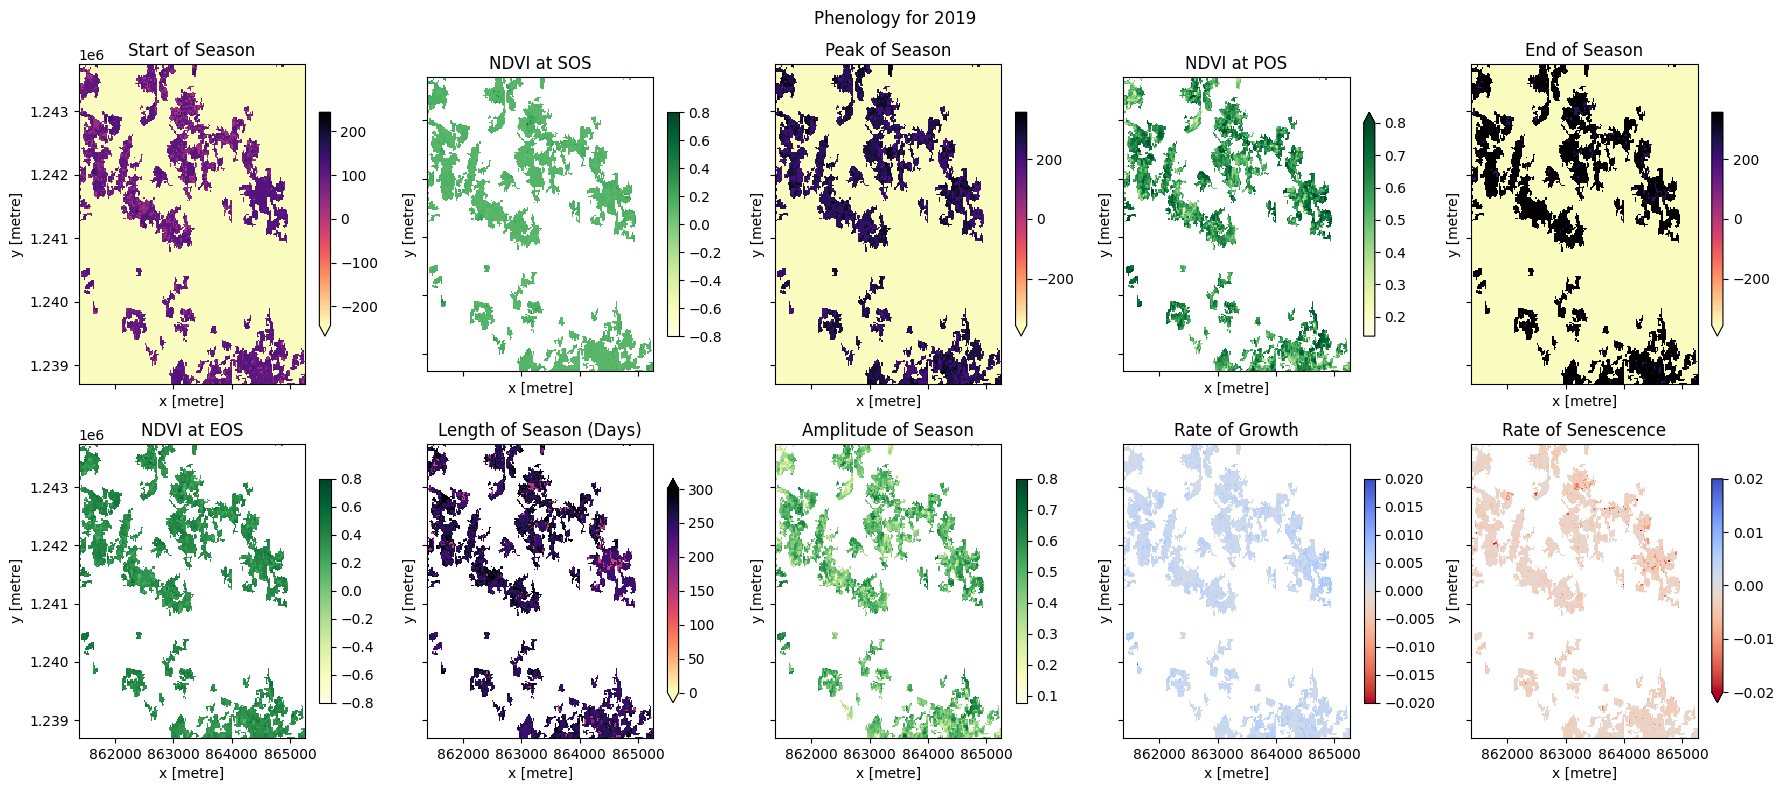

In [20]:
# select the year to plot
phen = pheno_results[year_to_plot]

# Define a few items to aid in plotting.
start_date = dt.date(int(year_to_plot), 1, 1)
end_date = dt.date(int(year_to_plot), 10, 27)

date_list = pd.date_range(start_date, end_date, freq="MS")
bounds = [int(i.strftime("%Y%m%d")) for i in date_list]


@mpl.ticker.FuncFormatter
def float_to_date(x, pos):
    tick_str = str(int(x))
    year = tick_str[:4]
    month = tick_str[4:6]
    day = tick_str[6:]
    return f"{year}-{month}-{day}"


# set up figure
fig, ax = plt.subplots(nrows=2,
                       ncols=5,
                       figsize=(18, 8),
                       sharex=True,
                       sharey=True)

# set colorbar size
cbar_size = 0.7

# set aspect ratios
for a in fig.axes:
    a.set_aspect("equal")

# start of season
# Convert SOS values from np.date64 to float values for plotting
cax = phen.SOS.dt.dayofyear.plot.imshow( 
    ax=ax[0, 0],
    cmap="magma_r",
#     levels=bounds,
    add_colorbar=True,
    cbar_kwargs=dict(shrink=cbar_size, label=None),
)
ax[0, 0].set_title("Start of Season")

phen.vSOS.plot(ax=ax[0, 1],
               cmap="YlGn",
               vmax=0.8,
               cbar_kwargs=dict(shrink=cbar_size, label=None))
ax[0, 1].set_title(veg_proxy + " at SOS")

# peak of season
# # Convert POS values from np.date64 to float values for plotting
cax = phen.POS.dt.dayofyear.plot.imshow(
    ax=ax[0, 2],
    cmap="magma_r",
#     levels=bounds,
    add_colorbar=True,
    cbar_kwargs=dict(shrink=cbar_size, label=None),
)
ax[0, 2].set_title("Peak of Season")

phen.vPOS.plot(ax=ax[0, 3],
               cmap="YlGn",
               vmax=0.8,
               cbar_kwargs=dict(shrink=cbar_size, label=None))
ax[0, 3].set_title(veg_proxy + " at POS")

# end of season
# Convert EOS values from np.date64 to float values for plotting
cax = phen.EOS.dt.dayofyear.plot.imshow( 
    ax=ax[0, 4],
    cmap="magma_r",
#     levels=bounds,
    add_colorbar=True,
    cbar_kwargs=dict(shrink=cbar_size, label=None),
)
ax[0, 4].set_title("End of Season")

phen.vEOS.plot(ax=ax[1, 0],
               cmap="YlGn",
               vmax=0.8,
               cbar_kwargs=dict(shrink=cbar_size, label=None))
ax[1, 0].set_title(veg_proxy + " at EOS")

# Length of Season
phen.LOS.plot(
    ax=ax[1, 1],
    cmap="magma_r",
    vmax=300,
    vmin=0,
    cbar_kwargs=dict(shrink=cbar_size, label=None),
)
ax[1, 1].set_title("Length of Season (Days)")

# Amplitude
phen.AOS.plot(ax=ax[1, 2],
              cmap="YlGn",
              vmax=0.8,
              cbar_kwargs=dict(shrink=cbar_size, label=None))
ax[1, 2].set_title("Amplitude of Season")

# rate of growth
phen.ROG.plot(
    ax=ax[1, 3],
    cmap="coolwarm_r",
    vmin=-0.02,
    vmax=0.02,
    cbar_kwargs=dict(shrink=cbar_size, label=None),
)
ax[1, 3].set_title("Rate of Growth")

# rate of Sensescence
phen.ROS.plot(
    ax=ax[1, 4],
    cmap="coolwarm_r",
    vmin=-0.02,
    vmax=0.02,
    cbar_kwargs=dict(shrink=cbar_size, label=None),
)
ax[1, 4].set_title("Rate of Senescence")
plt.suptitle("Phenology for " + year_to_plot)
plt.tight_layout();

## Conclusions

In the example above, we can see these four fields are following the same cropping schedule and are therefore likely the same species of crop. We can also observe intra-field differences in the rates of growth, and in the NDVI values at different times of the season, which may be attributable to differences in soil quality, watering intensity, or other farming practices. 

Phenology statistics are a powerful way to summarise the seasonal cycle of a plant's life.  Per-pixel plots of phenology can help us understand the timing of vegetation growth and sensecence across large areas and across diverse plant species as every pixel is treated as an independent series of observations. This could be important, for example, if we wanted to assess how the growing seasons are shifting as the climate warms.  


## Advanced: Calculating generic temporal statistics

In addition to the `xr_phenology` function, the DE Africa [deafrica_tools.temporal](../Tools/deafrica_tools/temporal.py) script contains another function for calculating generic time-series statistics, `temporal_statistics`.  This function is built upon the [hdstats library](https://github.com/daleroberts/hdstats) (a library of multivariate and high-dimensional statistics algorithms).
This function accepts a 2 or 3D time-series of, for example, NDVI, and computes a number of summary statistics including:
- discordance
- discrete fourier transform coefficients (mean, std, and median)
- median change
- absolute change
- complexity
- central difference
- number of peaks (very slow to run)

Below we will calculate a number of these statistics and plot them.

In [21]:
statistics = [
    "f_mean",
    "median_change",
    "abs_change",
    "complexity",
    "central_diff",
#     "discordance",
]

ts_stats = temporal_statistics(veg_smooth, statistics)
print(ts_stats)

   Statistics:
      f_mean
      median_change
      abs_change
      complexity
      central_diff
<xarray.Dataset>
Dimensions:        (y: 252, x: 194)
Coordinates:
  * x              (x) float64 8.614e+05 8.614e+05 ... 8.652e+05 8.652e+05
  * y              (y) float64 1.244e+06 1.244e+06 ... 1.239e+06 1.239e+06
    spatial_ref    int32 6933
Data variables:
    f_mean_n1      (y, x) float32 nan nan nan nan nan ... 1.6 1.596 1.505 1.374
    f_mean_n2      (y, x) float32 nan nan nan nan ... 0.3178 0.2889 0.2948
    f_mean_n3      (y, x) float32 nan nan nan nan ... 0.1461 0.1028 0.06091
    median_change  (y, x) float32 nan nan nan ... 0.0002928 0.0005613 -0.007481
    abs_change     (y, x) float32 nan nan nan nan ... 0.03267 0.02915 0.02999
    complexity     (y, x) float32 nan nan nan nan nan ... 5.229 3.647 4.273 4.01
    central_diff   (y, x) float32 nan nan nan ... -0.0005532 -0.000533


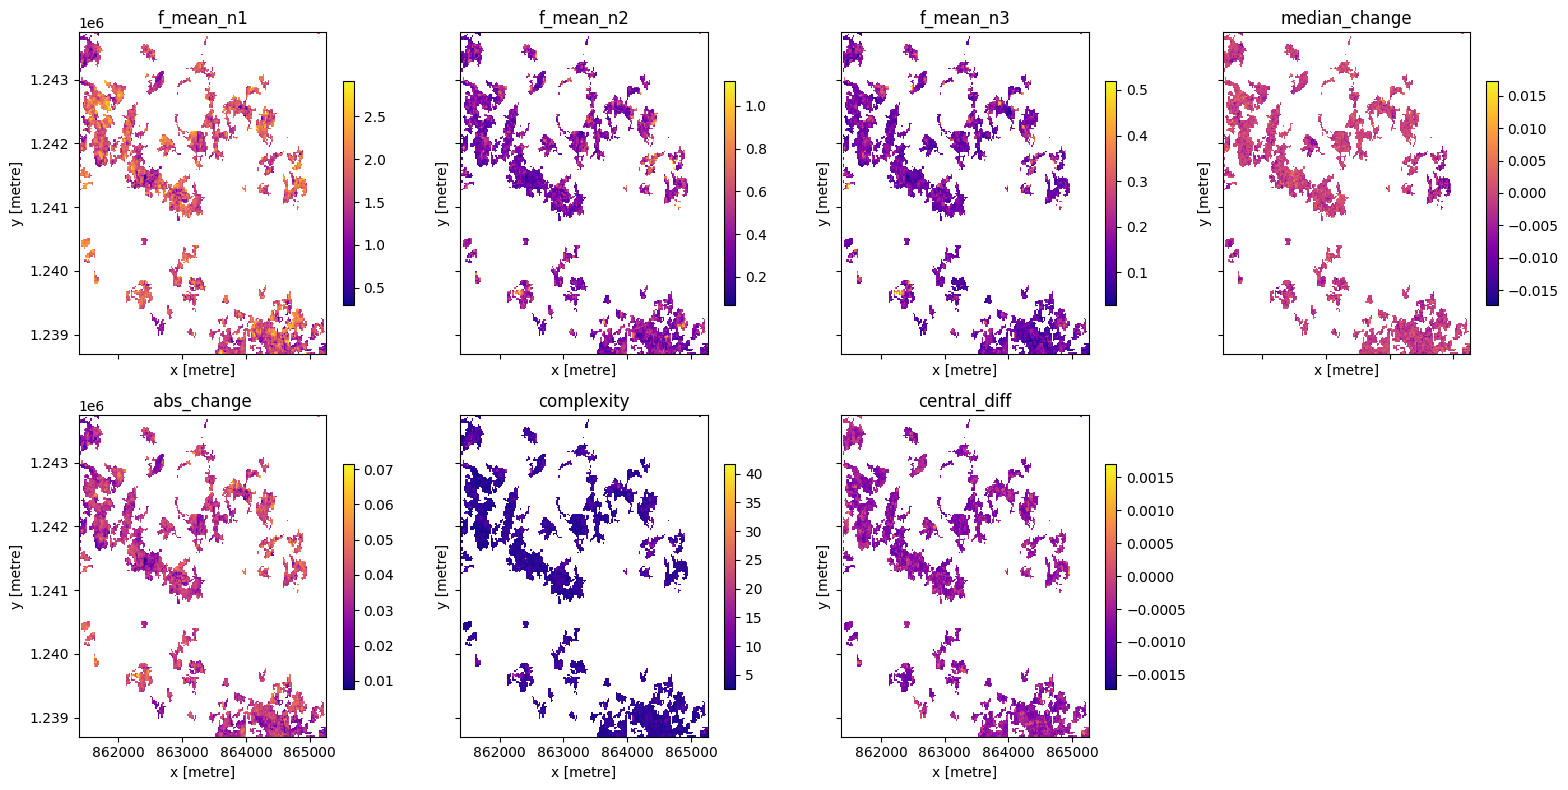

In [22]:
ts_stats = ts_stats.where(cm == 1)

# set up figure
fig, axes = plt.subplots(2, 4, figsize=(16, 8), sharey=True, sharex=True )

# set aspect ratios
for a in fig.axes:
    a.set_aspect("equal")

# set colorbar size
cbar_size = 0.7
stats = list(ts_stats.data_vars)

# plot
axx = 0
col = 0
for st in stats:
    if axx > 3:
        col += 1
        axx = 0
    ts_stats[st].plot(ax=axes[col][axx], cmap="plasma",cbar_kwargs=dict(shrink=cbar_size, label=None))
    axes[col][axx].set_title(st)
    axx += 1
    
if len(stats) < 8: fig.delaxes(axes[1][3])

plt.tight_layout();

## Next steps

When you're done, if you wish to run this code for another region, return to the "Analysis parameters" cell, modify some values (e.g. `time_range`,  or `lat`/`lon`) and rerun the analysis.

For advanced users, `xr_phenology` could be used for generating phenology feature layers in a machine learning classifier (see [Machine Learning with ODC](../Real_world_examples/Machine_learning_with_ODC.ipynb) for example of running ML models with ODC data).  `xr_phenology` can be passed inside of the `custom_func` parameter in the `deafrica_classificationtools.collect_training_data()` function, allowing phenological statistics to be computed during the collection of training data. An example would look like this:

    from deafrica_tools.temporal import xr_phenology
    from deafrica_tools.classification import collect_training_data

    def phenology_stats(da):
        stats = xr_phenology(da, complete='fast_complete')
        return stats

    training = collect_training_data(...,
                                     feature_func=phenology_stats)

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:** 

In [23]:
print(datacube.__version__)

1.8.15


**Last Tested:**

In [24]:
from datetime import datetime

datetime.today().strftime("%Y-%m-%d")

'2024-03-18'